# CONVOLUTIONAL NEURAL NETWORK (CNN) FOR CASTING PRODUCT QUALITY INSPECTION

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import keras,os
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Images

# Adding Train and test data for non augmented train set.

In [3]:
train_data_gen = image.ImageDataGenerator(rescale= 1./255)
train= train_data_gen.flow_from_directory(directory="/content/drive/MyDrive/Data for DAMG7245/casting_data/train" ,color_mode = "grayscale", target_size=(300,300) , batch_size=32, class_mode = 'binary')

Found 6633 images belonging to 2 classes.


In [4]:
train_data_gen = image.ImageDataGenerator(rescale= 1./255)
test= train_data_gen.flow_from_directory(directory="/content/drive/MyDrive/Data for DAMG7245/casting_data/test" ,color_mode = "grayscale", target_size=(300,300) , batch_size=32, class_mode = 'binary')

Found 715 images belonging to 2 classes.


Checking the tags

In [5]:
train.class_indices

{'def_front': 0, 'ok_front': 1}

In [6]:
test.class_indices


{'def_front': 0, 'ok_front': 1}

# Creating a model for Non augmented training dataset

In [7]:
IMAGE_SIZE = (300, 300)

In [8]:
modelnonaug = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

modelnonaug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 128)               6

# Compiling the model

In [9]:
modelnonaug.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

# Saving the model

In [10]:
checkpoints = ModelCheckpoint("cnn_casting_inspection_modelnonaug.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

# Training the model

In [11]:
modelnonaug.fit_generator(train,epochs=25,steps_per_epoch=100,validation_data=test,validation_steps=len(test),callbacks = [checkpoints])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.5772
Epoch 1: val_loss improved from inf to 0.58766, saving model to cnn_casting_inspection_modelnonaug.hdf5
100/100 [==============================] - 404s 4s/step - loss: 0.6739 - accuracy: 0.5772 - val_loss: 0.5877 - val_accuracy: 0.6503
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.7309
Epoch 2: val_loss improved from 0.58766 to 0.40957, saving model to cnn_casting_inspection_modelnonaug.hdf5
100/100 [==============================] - 133s 1s/step - loss: 0.5176 - accuracy: 0.7309 - val_loss: 0.4096 - val_accuracy: 0.7944
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8008
Epoch 3: val_loss improved from 0.40957 to 0.27391, saving model to cnn_casting_inspection_modelnonaug.hdf5
100/100 [==============================] - 83s 824ms/step - loss: 0.4104 - accuracy: 0.8008 - val_loss: 0.2739 - val_accuracy: 0

Visualizing the model Training Evaluation

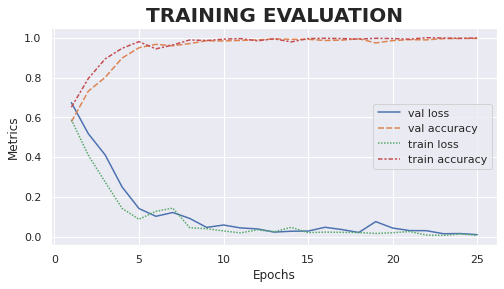

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize = (8, 4))
sns.lineplot(data = pd.DataFrame(modelnonaug.history.history,
                                 index = range(1, 1+len(modelnonaug.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

# Now performing Data Augmentation on Train dataset to create another model which improves fitting

## Data Augmentation

Using ImageDataGenerator from Keras for Data Augmentation:

- `rotation_range`: Degree range for random rotations. We choose 360 degrees since the product is a round object.
- `width_shift_range`: Fraction range of the total width to be shifted.
- `height_shift_range`: Fraction range of the total height to be shifted.
- `shear_range`: Degree range for random shear in a counter-clockwise direction.
- `zoom_range`: Fraction range for random zoom.
- `horizontal_flip` and `vertical_flip` are set to `True` for randomly flip image horizontally and vertically.
- `brightness_range`: Fraction range for picking a brightness shift value.
- `rescale`: Eescale the pixel values to be in range 0 and 1.
- `validation_split`: Reserve 20% of the training data for validation, and the rest 80% for model fitting.

In [23]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.05,
                                     zoom_range = 0.1,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.2, 1.5],
                                     rescale = 1./255)

We define another set of value for the `flow_from_directory` parameters:
- `IMAGE_DIR`: The directory where the image data is stored.
- `IMAGE_SIZE`: The dimension of the image (300 px by 300 px).
- `BATCH_SIZE`: Number of images that will be loaded and trained at one time.
- `SEED_NUMBER`: Ensure reproducibility.

- `color_mode = "grayscale"`: Treat our image with only one channel color.
- `class_mode` and `classes` define the target class of our problem. In this case, we denote the `defect` class as positive (1), and `ok` as a negative class.
- `shuffle = True` to make sure the model learns the `defect` and `ok` images alternately.

In [24]:
IMAGE_DIR = "/content/drive/MyDrive/Data for DAMG7245/casting_data/"
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                shuffle = True,
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",
                                                    subset = "training", **gen_args)

Found 6633 images belonging to 2 classes.


We successfully load and apply on-the-fly data augmentation according to the specified parameters to the train set.

We will not perform any data augmentation on the test data.

In [25]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "test",
                                                  **gen_args)

Found 715 images belonging to 2 classes.


# Visualize the Image
In this section, we visualize the image to make sure that it is loaded correctly.

## Visualize Image in Batch

Visualize the first batch (`BATCH_SIZE = 64`) of the training dataset (images with data augmentation) and also the test dataset (images without data augmentation).

In [26]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [27]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

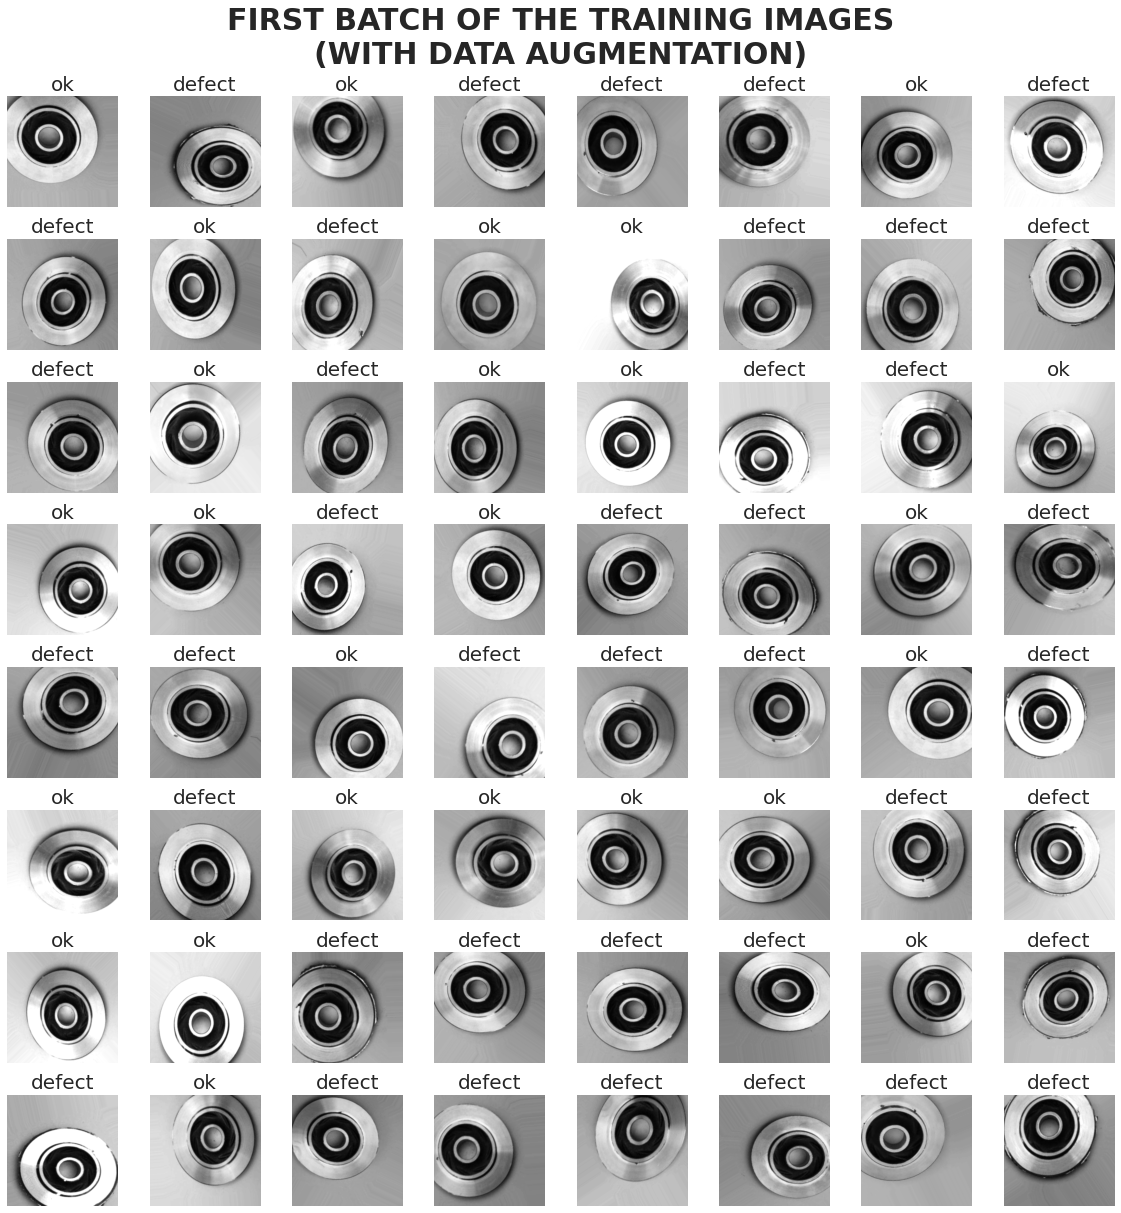

In [28]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

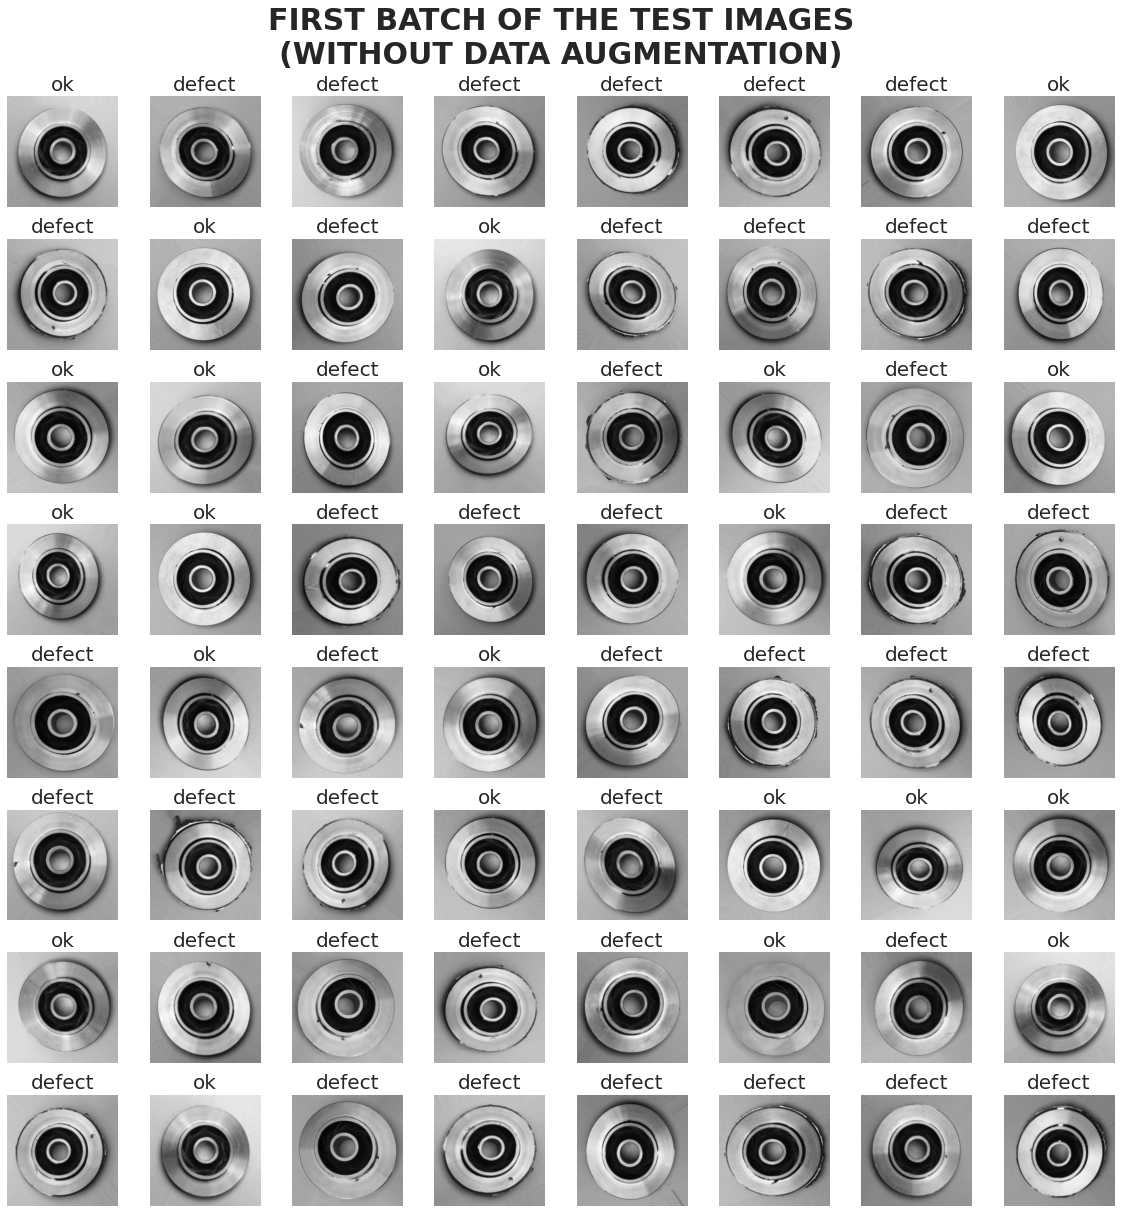

In [29]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

These are the example of values that we are going to feed into our CNN architecture.

In [30]:
model = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5184)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

## Compile the Model
Next, we specify how the model backpropagates or update the weights after each batch feed-forward. We use adam `optimizer` and a `loss` function binary cross-entropy since we are dealing with binary classification problem. The `metrics` used to monitor the training progress is accuracy.

In [31]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

## Model Fitting

In [32]:
checkpoint = ModelCheckpoint("cnn_casting_inspection_model.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "accuracy")

model.fit_generator(generator = train_dataset,
                    validation_data = test_dataset,
                    steps_per_epoch = 100,
                    epochs = 30,
                    callbacks = [checkpoint],
                    verbose = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5601
Epoch 1: accuracy improved from -inf to 0.56014, saving model to cnn_casting_inspection_model.hdf5
100/100 [==============================] - 137s 1s/step - loss: 0.6898 - accuracy: 0.5601 - val_loss: 0.6758 - val_accuracy: 0.6336
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5644
Epoch 2: accuracy improved from 0.56014 to 0.56437, saving model to cnn_casting_inspection_model.hdf5
100/100 [==============================] - 136s 1s/step - loss: 0.6857 - accuracy: 0.5644 - val_loss: 0.6724 - val_accuracy: 0.6336
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5659
Epoch 3: accuracy improved from 0.56437 to 0.56594, saving model to cnn_casting_inspection_model.hdf5
100/100 [==============================] - 133s 1s/step - loss: 0.6839 - accuracy: 0.5659 - val_loss: 0.6705 - val_accuracy: 0.6336
Epoch 4/30
10

The model achieves 92.73% accuracy on on validation dataset.

## Training Evaluation

Let's plot both `loss` and `accuracy` metrics for `train` and `validation` data based on each `epoch`.

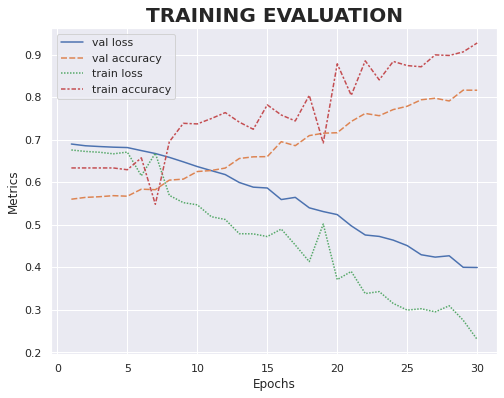

In [33]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

We can conclude that the model is **not overfitting** the data since both `train loss` and `val loss` simultaneously dropped towards zero. Also, both `train accuracy` and `val accuracy` increase towards 100%.

According to the problem statement, we want to minimize the case of False Negative, where the `defect` product is misclassified as `ok`. This can cause the whole order to be rejected and create a big loss for the company. Therefore, in this case, we prioritize Recall over Precision.

But if we take into account the cost of re-casting a product, we have to minimize the case of False Positive also, where the `ok` product is misclassified as `defect`. Therefore we can prioritize the F1 score which combines both Recall and Precision.

On test dataset, the model achieves a very good result as follow:
- Accuracy: 98.74%
- Recall: 98.45%
- Precision: 98.84%
- F1 score: 98.64%

Since the proportion of correctly classified images is very large, let's also visualize the misclassified only.

Out of 715 test images, only 9 images are being misclassified. 

# Conclusion

By using CNN and on-the-fly data augmentation, the performance of our model in training, validation, and test images is almost perfect, reaching 98-99% accuracy and F1 score. We can utilize this model by embedding it into a surveillance camera where the system can automatically separate defective product from the production line. This method surely can reduce human error and human resources on manual inspection, but it still needs supervision from human since the model is not 100% correct at all times.